# Replot Fig S1, S2 for Delta paper

## simulate trees

I don't have the previous simulated trees. Thus, I use the same funtion to simulate trees. For Fig. S1, S2, the group is a100N16K2D6.

### functions to simulate the trees

There is one file named 20180104LineageTreeComparisonSimmulation.ipynb I left there, which describes how trees were simulated.

In [2]:
F.sigmoid <- function(x, a=100){
  return (2 / (1 + exp(-a*x)) -1)
}

F.geneOF <- function(gene.level){
    if (any(gene.level > 1) || any(gene.level < -1)){
        print("warning! some gene.level is outside the value limit of -1<= gene.level <= 1")
    }
    return (as.numeric(gene.level > 0))
}

F.divide <- function(gene.level){
    if (gene.level[1] > 0){
        L <-  gene.level
        R <- gene.level
        L[1] <- -1
        R[1] <- -1
        if (gene.level[2] >0) L[2] <- -1
        return (data.frame(L,R))
    }
    return (NULL)
}

F.grow <- function(gene.level, gene.network, a = 100){
    return (F.sigmoid(as.vector(gene.network %*% gene.level), a))
}

F.randNetwork <- function(N,K,digits = NULL){
    gene.interactions = rnorm(N*K)
    gene.network = c(gene.interactions, rep(0, N*(N-K)))
    if (is.null(digits))
        return (matrix(sample(gene.network), ncol = N, nrow = N))
    else
        return (round((matrix(sample(gene.network), ncol = N, nrow = N)), digits))
}

F.randInit <- function(N){
    randInit <- c(-1,sample(c(1,-1), size = N-1, replace = TRUE))
    return (randInit)
}

F.develop <- function(gene.init, gene.network, tmax = 50, Dmax = 10, a = 100){
    gene.OF <- F.geneOF(gene.init)
    cell.tree  <- Node$new(name = "Root", DAge = 0, tAge = 0, Lineage="", Gene.level = gene.init, Gene.OF = gene.OF)
    tAge = 0
    DAge = 0
    while (TRUE){
        if (tAge > tmax || DAge > Dmax) break
        for (cell.leaf in cell.tree$leaves){
            cell.divide = F.divide(cell.leaf$Gene.level)
            if (is.null(cell.divide)){
                tAge  <- cell.leaf$tAge + 1
                if (tAge > tmax || DAge > Dmax) break
                name  <- "LR"
                DAge <- cell.leaf$DAge
                Lineage <- cell.leaf$Lineage
                Gene.level <- F.grow(cell.leaf$Gene.level, gene.network = gene.network, a = a)
                Gene.OF <- F.geneOF(Gene.level)
#                 cell.leaf$AddChild(name = name, DAge = DAge, tAge = tAge, 
#                                    Lineage = Lineage, Gene.level = Gene.level, Gene.OF = Gene.OF)
                
#                 cell.leaf$name <- name
                cell.leaf$DAge <- DAge
                cell.leaf$tAge <- tAge
                cell.leaf$Lineage <- Lineage
                cell.leaf$Gene.level <- Gene.level
                cell.leaf$Gene.OF <- Gene.OF
            }
            else {
                tAge <- cell.leaf$tAge + 1
                DAge <- cell.leaf$DAge + 1
                if (tAge > tmax || DAge > Dmax) break
                Lname <- "L"
                LLineage <- paste0(cell.leaf$Lineage,"0")
                Rname <- "R"
                RLineage <- paste0(cell.leaf$Lineage,"1")
                LRinit <- F.divide(cell.leaf$Gene.level)
                LGene.level <- F.grow(LRinit$L, gene.network = gene.network, a = a)
                RGene.level <- F.grow(LRinit$R, gene.network = gene.network, a = a)
                LGene.OF  <- F.geneOF(LGene.level)
                RGene.OF <- F.geneOF(RGene.level)
                cell.leaf$AddChild(name = Lname, DAge = DAge, tAge = tAge, 
                                   Lineage = LLineage, Gene.level = LGene.level, Gene.OF = LGene.OF)
                cell.leaf$AddChild(name = Rname, DAge = DAge, tAge = tAge, 
                                   Lineage = RLineage, Gene.level = RGene.level, Gene.OF = RGene.OF)
            }
        }
    }
    return (cell.tree)
}

F.saveRandomTree <- function(cell.tree, network = NULL, score = "common", 
                             class = "Gene.OF", outfilePrefix = "",silent = FALSE) {
    cell.tree.dfAll <- ToDataFrameTree(cell.tree,"pathString","level","name",'Lineage', 'DAge','tAge',
                                     Gene.OF = function(node) paste0(node$Gene.OF, collapse = ''),
                                     Gene.level = function(node) paste0(node$Gene.level, collapse = ';'),
                                     isLeaf = function(node) node$isLeaf)
    outfile.cell.tree.all <- paste0(outfilePrefix, "cell.tree.all")
    write.table(cell.tree.dfAll, outfile.cell.tree.all, sep="\t", row.names = FALSE)
    if (!silent) print(paste0("write the all details for the tree to file ", outfile.cell.tree.all))
    
    cell.tree.dfLeaf <- ToDataFrameTable(cell.tree,"pathString","level","name",'Lineage', 'DAge','tAge',
                                         Gene.OF = function(node) paste0(node$Gene.OF, collapse = ''))
    cell.tree.Leaf <- cell.tree.dfLeaf[,c("Lineage","name","Gene.OF")]
    outfile.cell.tree.leaves <- paste0(outfilePrefix, "cell.tree.leaves")
    write.table(cell.tree.Leaf, outfile.cell.tree.leaves,sep = "\t", row.names = FALSE, quote = FALSE)
    #remove the last newline symbol in outfile.cell.tree.leaves
    txt <- readChar(outfile.cell.tree.leaves,file.info(outfile.cell.tree.leaves)$size,useByte = TRUE)
    txt <- gsub("\r","",txt)
    if (substr(txt,nchar(txt),nchar(txt)) == "\n")
        cat(substr(txt,1,nchar(txt)-1), file = outfile.cell.tree.leaves)
    if (!silent) print(paste0("write the leaves file for HSA to ", outfile.cell.tree.leaves))
    
    outfile.cell.tree.score <- paste0(outfilePrefix, "cell.tree.score")
    gene.OF <- cell.tree.dfLeaf$Gene.OF
    if (length(unique(gene.OF)) > 2)
        gene.OF.pairs <- combn(unique(gene.OF),2)
    else
        gene.OF.pairs <- NULL
    dfscore <- data.frame(S=c(unique(gene.OF),gene.OF.pairs[1,]), T=c(unique(gene.OF),gene.OF.pairs[2,]))
    if (score == "common")
        dfscore$Score <- apply(dfscore,1,function(x) sum(unlist(strsplit(x["S"],"")) == unlist(strsplit(x["T"],""))))
    else if (score == "same")
        dfscore$Score <- (dfscore$S == dfscore$T)*2
    else if (score == "norm"){
        dfscore$Score <- apply(dfscore,1,function(x) sum(unlist(strsplit(x["S"],"")) == unlist(strsplit(x["T"],""))))
        dfscore$Score <- round((dfscore$Score - mean(dfscore$Score))/sd(dfscore$Score)) + 1
    } else if (!silent) print("invalid value for score, score can be same, common or norm")
        
    write.table(dfscore, outfile.cell.tree.score, sep = "\t", row.names = FALSE, col.names = FALSE, quote = FALSE)
    if (!silent) print(paste0("write the score file to ", outfile.cell.tree.score))
    
    if (!is.null(network)) {
        outfile.network  <- paste0(outfilePrefix, "cell.tree.network")
        write.table(network, outfile.network, sep = "\t", row.names = FALSE, col.names = FALSE, quote = FALSE)
        print(paste0("write the interaction network to file ", outfile.network))
    }
    else if (!silent) print("You need to provide Network in order to save it!")
}

In [3]:
F.generateRandTree <- function(a, N, K, Dmax, tmax, digits = 3){
    gene.init  <- F.randInit(N)
    gene.network <- F.randNetwork(N, K, digits = digits)
    cell.tree <- F.develop(gene.init, gene.network, tmax = tmax, Dmax = Dmax, a = a)
    return(list(gene.init = gene.init, gene.network = gene.network, cell.tree = cell.tree))
}

F.treeCellType <- function(tree1){
    gene.OF <- lapply(tree1$leaves, function(node) paste0(node$Gene.OF,collapse = ""))
    return(length(unique(unlist(gene.OF))))
}

In [4]:
F.generateRandTreeWithFilter  <- function(a, N, K, Dmax, tmax, digits = 3, 
                                          leafTypeMin = 6, leafCountMin = 500, tryMax = 100){
    for (i in 1:tryMax){
        celltree <- F.generateRandTree(a = a, N = N, K=K, Dmax = Dmax, tmax = tmax, digits = digits)
        leafTypeCount <- F.treeCellType(celltree[["cell.tree"]])
        leafCount <- celltree[["cell.tree"]]$leafCount
        celltree$leafTypeCount <- leafTypeCount
        celltree$leafCount <- leafCount
        if (leafCount >= leafCountMin && leafTypeCount >= leafTypeMin){
            return(celltree)
        }
    }
    print(paste0("tried ", tryMax, " times. Still No good. return NULL"))
    return(NULL)
}

### simulate trees for a100N16K2D6

In [10]:
library(data.tree)
library(parallel)

In [11]:
leafTypeMin = 4
leafCountMin = 16

In [5]:
df.settingD6 = data.frame(a = c(1,10,100,100,100,100,100), 
                        N = c(16,16,16,16,16,8,32),
                        K = c(4,4,2,4,8,4,4),
                        Dmax = rep(6,7),
                        tmax = rep(50,7))
df.settingD6

a,N,K,Dmax,tmax
1,16,4,6,50
10,16,4,6,50
100,16,2,6,50
100,16,4,6,50
100,16,8,6,50
100,8,4,6,50
100,32,4,6,50


In [7]:
for (i in c(3)){
    s <- df.settingD6[i,]
    folder <- paste0("/home/xcao/w/temp/a",s$a,"N",s$N,"K",s$K,"D",s$Dmax,"/")
    dir.create(folder)
}

In [12]:
for (i in c(3)){
    s <- df.settingD6[i,]
    folder <- paste0("/home/xcao/w/temp/a",s$a,"N",s$N,"K",s$K,"D",s$Dmax,"/")
    fileInfo <- paste0("/home/xcao/w/temp/a",s$a,"N",s$N,"K",s$K,"D",s$Dmax,".info")
    fileInfoWrite <- file(fileInfo,"w")
    for (n in 1:1000){
        tr <- F.generateRandTreeWithFilter(a = s$a, N = s$N, K = s$K, Dmax = s$Dmax, 
                                            tmax = s$tmax, digits = 4,
                                            leafTypeMin = leafTypeMin,
                                            leafCountMin = leafCountMin, tryMax = 100)
        filenamePrefix <- paste0(folder,"a",s$a,"N",s$N,"K",s$K,"D",s$Dmax,"ID",n)
        F.saveRandomTree(cell.tree = tr$cell.tree, network = NULL, score = "norm", class = "Gene.OF", 
                         outfilePrefix = filenamePrefix, silent = TRUE)
        writeLines(text = c(paste0("ID=",n,";a=",s$a,";N=",s$N,";K=",s$K,";L=",tr$leafCount,";T=",tr$leafTypeCount),
                       paste(tr$gene.init,collapse = " "),
                       paste(as.vector(tr$gene.network), collapse = " ")), con = fileInfoWrite)
    }
    close(fileInfoWrite)
}

### run DELTA

Note: code below runs in python

In [2]:
import os
import glob
workfolder = '/home/xcao/w/temp/'
files_trees = glob.glob(workfolder+'a100N16K2D6/*.leaves')

#### define the function

In [3]:
def runDELTA(t_leaves):
    '''
    t_leaves is the filename in files_trees. Run DELTA for one of them
    '''
    t_cost = t_leaves[:-6]+"score"
    t_HSA = '/home/xcao/p/delta/DELTA/bin/Release/DELTA'
    t_out = t_leaves[:-6]+"alignments"

    commandline = "{HSA} -treeS {treeS} -treeT {treeT} -cost {cost} -outfile {outfile}".format(\
                    HSA = t_HSA, treeS = t_leaves, treeT = t_leaves, cost = t_cost, \
                    outfile = t_out +\
                    " -method l -max_target 20 -test 1000 ")
    os.system(commandline)

#### run for all trees

In [ ]:
from multiprocessing import Pool
pool = Pool(32) # use 32 CPUs
pool.map(runDELTA, files_trees)
pool.close()

In [ ]:
fout = open("20180126ScriptsD6.txt","w")
for i in ls_D6:
    fout.write("{HSA} -treeS {treeS} -treeT {treeT} -cost {cost} -outfile {outfile}".format(\
                HSA = t_HSA, treeS = i, treeT = i, cost = i[:-6]+"score", \
                outfile = i.replace("2018simulation","2018Result").replace("tree.leaves","tree.alignments")) +\
                " -method l -max_target 20 -test 1000 \n")
fout.close()

### collect the data

code below runs in R

#### functions

In [37]:
F.readInfo <- function(filename){
    f.lines <- readLines(filename)
    f.length <- length(f.lines)
    n <- f.length %/% 3
    lines.des <- f.lines[c(1:n * 3 - 2)]
    lines.init <- f.lines[c(1:n * 3 - 1)]
    lines.network <- f.lines[c(1:n * 3)]
    df.des <- do.call(rbind,strsplit(lines.des,split = ";"))
    df.simulation <- data.frame(ID = as.numeric(do.call(rbind,strsplit(df.des[,1],split = "="))[,2]),
                               a = as.numeric(do.call(rbind,strsplit(df.des[,2],split = "="))[,2]),
                               N = as.numeric(do.call(rbind,strsplit(df.des[,3],split = "="))[,2]),
                               K = as.numeric(do.call(rbind,strsplit(df.des[,4],split = "="))[,2]),
                               D = 6, #simulation here has no D
                               L = as.numeric(do.call(rbind,strsplit(df.des[,5],split = "="))[,2]),
                               T = as.numeric(do.call(rbind,strsplit(df.des[,6],split = "="))[,2]))
    df.simulation$init <- lapply(strsplit(lines.init, split = " "), as.numeric)
    df.simulation$network <- lapply(strsplit(lines.network, split = " "), as.numeric)
    gene.number <- df.simulation$N[1]
    for (i in 1:n){
        df.simulation$network[[i]] <- matrix(df.simulation$network[[i]], df.simulation$N)
    }
    return(df.simulation)
}

F.readTreeAlignments <- function(filename){
    f.lines <- readLines(filename)
    f.length <- length(f.lines)
    t.count <- f.length %/% 13
    alignments.id <- sub("{", "", f.lines[1:t.count * 9 - 8], fixed = TRUE)
    alignments.Score <- sub("Score:", "", f.lines[1:t.count * 9 - 7], fixed = TRUE)
    alignments.RootS <- sub("RootS:", "", f.lines[1:t.count * 9 - 6], fixed = TRUE)
    alignments.RootT <- sub("RootT:", "", f.lines[1:t.count * 9 - 5], fixed = TRUE)
    alignments.pvalue <- f.lines[1:t.count * 4 + 9 * t.count-1]
    alignments.pvalue <- rapply(strsplit(alignments.pvalue, " "), function(x)sub("pvalue:","",x[4], fixed = TRUE))
    alignments.random <- f.lines[1:t.count * 4 + 9 * t.count-2]
    alignments.random <- strsplit(sub('PValue:', '', alignments.random, fixed = TRUE), ' ')
    alignments.log10Pvalue <- mapply(function(x,y){
            x <- as.numeric(x)
            y <- as.numeric(y)
            z <- (x-mean(y))/sd(y)
            return((pnorm(-abs(z), log.p = TRUE)+log(2))/log(10))
        }, alignments.Score,alignments.random)
    alignments.MatchS <- f.lines[1:t.count * 9 - 2]
    alignments.MatchLength <- str_count(alignments.MatchS, " ") + 2
    alignments <- data.frame(id = alignments.id,
                            Score = as.numeric(alignments.Score),
                            RootS = alignments.RootS,
                            RootT = alignments.RootT,
                            pvalue = as.numeric(alignments.pvalue),
                            MatchLength = alignments.MatchLength,
                            log10Pvalue = alignments.log10Pvalue,
                            stringsAsFactors = FALSE)
    return(alignments)
}

F.getGeneLevel <- function(filename){
    df.all <- read.csv(file = filename, sep = "\t", stringsAsFactors = FALSE, colClasses = "character")
    gene.level <- strsplit(df.all$Gene.level,split = ";")
    mt.geneLevel <- matrix(as.numeric(unlist(gene.level)),ncol = length(gene.level[[1]]),byrow = TRUE)
    if (df.all$Lineage[1] == "")
        df.all$Lineage[1] <- "Root"
    row.names(mt.geneLevel) <- df.all$Lineage
    return(mt.geneLevel)
}

F.readTreeAlignmentsGeneLevel <- function(filenameAlign,filenameAll, 
                                          corMethod = "pearson", 
                                          testCor = TRUE, 
                                          testCorCase = 100){
    mt.geneLevel <- F.getGeneLevel(filenameAll)
    f.lines <- readLines(filenameAlign)
    f.length <- length(f.lines)
    t.count <- f.length %/% 14
    alignments.id <- sub("{", "", f.lines[1:t.count * 9 - 8], fixed = TRUE)
    alignments.Score <- sub("Score:", "", f.lines[1:t.count * 9 - 7], fixed = TRUE)
    alignments.RootS <- sub("RootS:", "", f.lines[1:t.count * 9 - 6], fixed = TRUE)
    alignments.RootT <- sub("RootT:", "", f.lines[1:t.count * 9 - 5], fixed = TRUE)
    alignments.pvalue <- f.lines[1:t.count * 5 + 9 * t.count-1]
    alignments.pvalue <- rapply(strsplit(alignments.pvalue, " "), function(x)sub("P-value:","",x[4], fixed = TRUE))
    
    alignments.random <- f.lines[1:t.count * 5 + 9 * t.count-2]
    alignments.random <- strsplit(sub('DELTA score between random trees:', '', alignments.random, fixed = TRUE), ' ')
    alignments.log10Pvalue <- mapply(function(x,y){
            x <- as.numeric(x)
            y <- as.numeric(y)
            z <- (x-mean(y))/sd(y)
            return((pnorm(-abs(z), log.p = TRUE)+log(2))/log(10))
        }, alignments.Score,alignments.random)
    
    alignments.MatchS <- f.lines[1:t.count * 9 - 2]
    alignments.MatchT <- f.lines[1:t.count * 9 - 1]
    alignments.MatchS <- strsplit(sub('MatchS:', '', alignments.MatchS, fixed = TRUE),split = " ")
    alignments.MatchT <- strsplit(sub('MatchT:', '', alignments.MatchT, fixed = TRUE),split = " ")
    alignments.MatchS <- lapply(1:t.count,function(x)c(alignments.RootS[x], alignments.MatchS[[x]]))
    alignments.MatchT <- lapply(1:t.count,function(x)c(alignments.RootT[x], alignments.MatchT[[x]]))
    
    geneCor <- lapply(1:t.count,function(x)cor(as.vector(mt.geneLevel[alignments.MatchS[[x]],]),
                                               as.vector(mt.geneLevel[alignments.MatchT[[x]],]),
                                               method = corMethod))
    geneCor <- unlist(geneCor)
    if (testCor){
        geneCorPvalue <- lapply(1:t.count, function(x){
            test.Cor <- cor(as.vector(mt.geneLevel[alignments.MatchS[[x]],]),
                            as.vector(mt.geneLevel[alignments.MatchT[[x]],]),
                            method = corMethod)
            test.Cor.Rand <- lapply(1:testCorCase,
                                    function(y)cor(as.vector(mt.geneLevel[alignments.MatchS[[x]],]),
                                                   as.vector(mt.geneLevel[sample(alignments.MatchT[[x]]),]),
                                                   method = corMethod))
            test.Cor.Rand <- unlist(test.Cor.Rand)
            z <- (test.Cor-mean(test.Cor.Rand))/sd(test.Cor.Rand)
            return((pnorm(-abs(z), log.p = TRUE)+log(2))/log(10))
            #return(2*pnorm(-abs(z)))
            })
        geneCorPvalue <- unlist(geneCorPvalue)
    } else {
        geneCorPvalue <- NA
    }
                                
    
    alignments.MatchLength <- str_count(alignments.MatchS, " ") + 1
    alignments <- data.frame(id = alignments.id,
                            Score = as.numeric(alignments.Score),
                            RootS = alignments.RootS,
                            RootT = alignments.RootT,
                            pvalue = as.numeric(alignments.pvalue),
                            log10Pvalue = alignments.log10Pvalue,
                            MatchLength = alignments.MatchLength,
                            GeneCor = geneCor,
                            GeneCorPvalue = geneCorPvalue,
                            stringsAsFactors = FALSE)
    return(alignments)
}



In [11]:
library("data.tree")
library("ggplot2")
library("dplyr")
library("stringr")
library(parallel)


Attaching package: 'dplyr'

The following objects are masked from 'package:stats':

    filter, lag

The following objects are masked from 'package:base':

    intersect, setdiff, setequal, union



#### collect simulation info

In [39]:
df.setting = data.frame(a = c(1,10,100,100,100,100,100), 
                        N = c(16,16,16,16,16,8,32),
                        K = c(4,4,2,4,8,4,4),
                        Dmax = rep(6,7),
                        tmax = rep(50,7))
df.setting

a,N,K,Dmax,tmax
1,16,4,6,50
10,16,4,6,50
100,16,2,6,50
100,16,4,6,50
100,16,8,6,50
100,8,4,6,50
100,32,4,6,50


In [42]:
folder <- "/home/xcao/w/temp/"
filenames.info  <- "/home/xcao/w/temp/a100N16K2D6.info"
df.simuInfo <- F.readInfo(filename = filenames.info)
df.simuInfo$group <- paste0("a", df.simuInfo$a, "N", df.simuInfo$N, "K", df.simuInfo$K, "D", df.simuInfo$D)
head(df.simuInfo,1)

ID,a,N,K,D,L,T,init,network,group
1,100,16,2,6,20,5,"-1, 1, -1, 1, -1, 1, -1, 1, -1, 1, -1, 1, 1, -1, 1, -1","0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.3728, 0.0000, 0.0000, 0.0000, -1.1479, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, -1.7960, 0.0000, 0.0000, 0.0000, 0.0000, 1.5842, 0.0000, 0.0000, -0.2494, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, -0.5857, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.1422, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.6395, 0.0000, -1.1460, 0.0000, 0.0000, 0.0000, 0.0000, 0.3564, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.3987, 0.0000, -0.5268, -0.1941, 0.0000, 0.0000, 0.8930, 0.0000, 0.0000, 0.0000, 0.3166, 0.2742, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, -0.1981, -0.1893, 1.0855, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, -0.2679, -1.3494, 0.0000, 0.0000, 0.0000, -1.1698, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, -1.2010, 0.0000, -0.0901, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, -0.1342, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, -1.1699, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.6785, 0.0000, 0.0000, 0.9205, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.3078, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, -0.6767, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, -0.4424, 0.0000, 0.0000, -0.2662, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000",a100N16K2D6


#### collect alignments, get file locations

each simulation, there are 4 files: "Sall","Sscore","Sleaves","Salign"

In [43]:
df.alignmentsInfo <- df.simuInfo[,c("ID","a","N","K","L","T","D", "group")]
head(df.alignmentsInfo)
dim(df.alignmentsInfo)

ID,a,N,K,L,T,D,group
1,100,16,2,20,5,6,a100N16K2D6
2,100,16,2,48,16,6,a100N16K2D6
3,100,16,2,35,8,6,a100N16K2D6
4,100,16,2,64,5,6,a100N16K2D6
5,100,16,2,33,4,6,a100N16K2D6
6,100,16,2,36,16,6,a100N16K2D6


[1] 1000    8

In [44]:
F.TempGetFullPath <- function(x,folder,postfix){
    tempFullPath <- paste0(folder, x["group"],"ID",x["ID"],postfix, collapse = "")
    tempFullPath <- gsub(" ","", tempFullPath)
    return(tempFullPath)
}

In [45]:
folder <- '/home/xcao/w/temp/a100N16K2D6/'
folderResult  <- folder
df.alignmentsInfo$Sall <- apply(df.alignmentsInfo,1,F.TempGetFullPath, folder = folder, postfix = "cell.tree.all")
df.alignmentsInfo$Sscore <- apply(df.alignmentsInfo,1,F.TempGetFullPath, folder = folder, postfix = "cell.tree.score")
df.alignmentsInfo$Sleaves <- apply(df.alignmentsInfo,1,F.TempGetFullPath, folder = folder, postfix = "cell.tree.leaves")
df.alignmentsInfo$Salign <- apply(df.alignmentsInfo,1, F.TempGetFullPath, 
                                  folder = folderResult, postfix = "cell.tree.alignments")
df.alignmentsInfo[c(1,10),]

,ID,a,N,K,L,T,D,group,Sall,Sscore,Sleaves,Salign
1,1,100,16,2,20,5,6,a100N16K2D6,/home/xcao/w/temp/a100N16K2D6/a100N16K2D6ID1cell.tree.all,/home/xcao/w/temp/a100N16K2D6/a100N16K2D6ID1cell.tree.score,/home/xcao/w/temp/a100N16K2D6/a100N16K2D6ID1cell.tree.leaves,/home/xcao/w/temp/a100N16K2D6/a100N16K2D6ID1cell.tree.alignments
10,10,100,16,2,37,7,6,a100N16K2D6,/home/xcao/w/temp/a100N16K2D6/a100N16K2D6ID10cell.tree.all,/home/xcao/w/temp/a100N16K2D6/a100N16K2D6ID10cell.tree.score,/home/xcao/w/temp/a100N16K2D6/a100N16K2D6ID10cell.tree.leaves,/home/xcao/w/temp/a100N16K2D6/a100N16K2D6ID10cell.tree.alignments


#### read and extract info from 1,000 alignments


In [3]:
df.alignmentsRead <- df.alignmentsInfo[,-(9:12)]
head(df.alignmentsRead)

ERROR: Error in eval(expr, envir, enclos): object 'df.alignmentsInfo' not found


In [1]:
c1 <- makeCluster(32,type = "FORK")

ERROR: Error in makeCluster(32, type = "FORK"): could not find function "makeCluster"


In [ ]:
df.alignmentsRead$alignments <- clusterMap(c1, 
                                           F.readTreeAlignmentsGeneLevel, 
                                           df.alignmentsInfo$Salign, 
                                           df.alignmentsInfo$Sall)

In [2]:
stopCluster(c1)

ERROR: Error in stopCluster(c1): could not find function "stopCluster"


In [ ]:
df.alignments <- do.call(rbind, df.alignmentsRead$alignments)
row.names(df.alignments) <- c()
colnames(df.alignments)[1] <- "AlignID"
head(df.alignments)
dim1aligns <- unlist(lapply(df.alignmentsRead$alignments,function(x)dim(x)[1]))
df.alignments$ID <- rep(df.alignmentsRead$ID, times = dim1aligns)
df.alignments$a <- rep(df.alignmentsRead$a, times = dim1aligns)
df.alignments$N <- rep(df.alignmentsRead$N, times = dim1aligns)
df.alignments$K <- rep(df.alignmentsRead$K, times = dim1aligns)
df.alignments$L <- rep(df.alignmentsRead$L, times = dim1aligns)
df.alignments$T <- rep(df.alignmentsRead$T, times = dim1aligns)
df.alignments$D <- rep(df.alignmentsRead$D, times = dim1aligns)
df.alignments$group <- rep(df.alignmentsRead$group, times = dim1aligns)

In [ ]:
write.csv(df.alignments,"/home/xcao/w/temp/20181028SimulationResultFinalDF.csv")

### plot simulation

In [4]:
filename <- "/home/xcao/w/temp/20181028SimulationResultFinalDF.csv"
df.alignments <- read.csv(file = filename, 
                          sep = ",", 
                          stringsAsFactors = FALSE, 
                          #colClasses = c(rep("numeric",3),rep("character",2),rep("numeric",11),"character"),
                          row.names = 1)


In [5]:
df.alignments$File <- paste0(df.alignments$group,"_",df.alignments$ID)
df.alignments$GeneCorZ <- df.alignments$GeneCor * sqrt((df.alignments$MatchLength * df.alignments$N - 3) / 1.06)
dim(df.alignments)

[1] 20000    19

In [6]:
groups <- unique(df.alignments$group)
groups

[1] "a100N16K2D6"

In [7]:
df.alignments <- df.alignments[df.alignments$MatchLength != 1, ]
df.alignments <- df.alignments[df.alignments$AlignID != 1,]

#### plot log10Pvalue vs MatchLength
Fig. S1


Call:
lm(formula = log10Pvalue ~ MatchLength, data = df.use)

Residuals:
    Min      1Q  Median      3Q     Max 
-52.163  -1.637  -0.324   1.810  24.133 

Coefficients:
             Estimate Std. Error t value Pr(>|t|)    
(Intercept)  0.693499   0.059264    11.7   <2e-16 ***
MatchLength -0.394097   0.002738  -144.0   <2e-16 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 4.92 on 18819 degrees of freedom
Multiple R-squared:  0.5241,	Adjusted R-squared:  0.5241 
F-statistic: 2.072e+04 on 1 and 18819 DF,  p-value: < 2.2e-16


ERROR: Error in glance(fit): could not find function "glance"


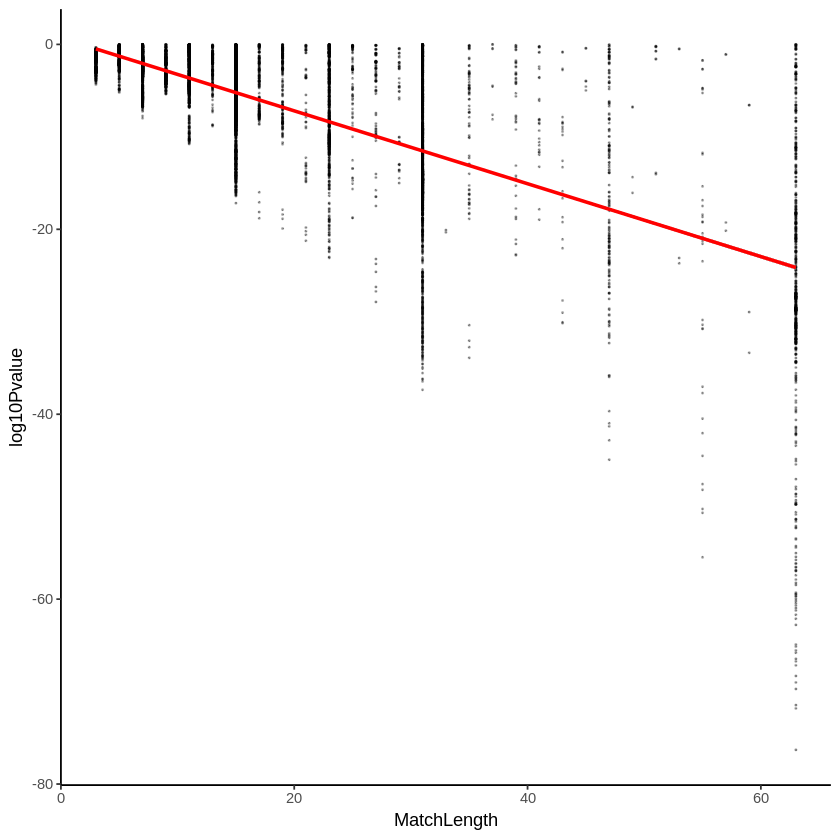

In [12]:
df.alignments %>% 
    filter(group == "a100N16K2D6") %>%
    ggplot(aes(x = MatchLength, y = log10Pvalue)) + 
        geom_point(size = 0.2, alpha = 0.3) + 
        geom_smooth(method = "lm", color = "red") + 
        theme_bw() + theme(panel.border = element_blank(), panel.grid.major = element_blank(),
                            panel.grid.minor = element_blank(), axis.line = element_line(colour = "black"))
df.use <- df.alignments %>% 
    filter(group == "a100N16K2D6")
fit <- lm(log10Pvalue ~ MatchLength, data = df.use)
summary(fit)
glance(fit)

#### plot log10Pvalue vs Score
Fig. S2


Call:
lm(formula = log10Pvalue ~ Score, data = df.use)

Residuals:
     Min       1Q   Median       3Q      Max 
-30.6422  -1.2960  -0.3819   1.2340  16.7201 

Coefficients:
             Estimate Std. Error t value Pr(>|t|)    
(Intercept)  2.304080   0.035038   65.76   <2e-16 ***
Score       -0.499575   0.001648 -303.14   <2e-16 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 2.94 on 18819 degrees of freedom
Multiple R-squared:   0.83,	Adjusted R-squared:   0.83 
F-statistic: 9.189e+04 on 1 and 18819 DF,  p-value: < 2.2e-16


ERROR: Error in glance(fit): could not find function "glance"


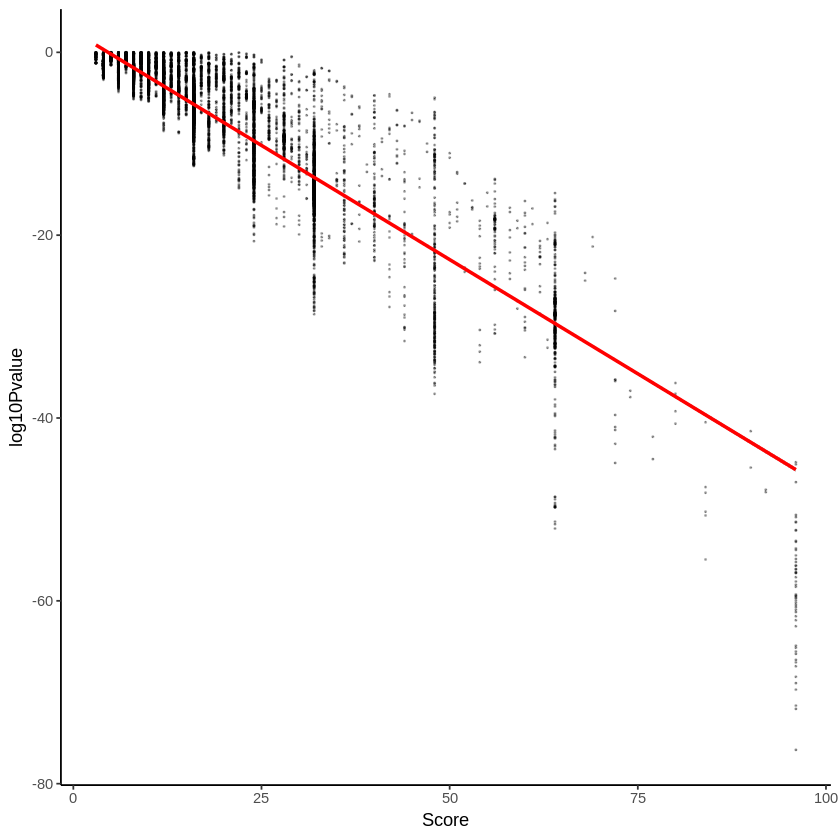

In [13]:
df.alignments %>% 
    filter(group == "a100N16K2D6") %>%
    ggplot(aes(x = Score, y = log10Pvalue)) + 
        geom_point(size = 0.2, alpha = 0.3) + 
        geom_smooth(method = "lm", color = "red") + 
        theme_bw() + theme(panel.border = element_blank(), panel.grid.major = element_blank(),
                            panel.grid.minor = element_blank(), axis.line = element_line(colour = "black"))
df.use <- df.alignments %>% 
    filter(group == "a100N16K2D6")
fit <- lm(log10Pvalue ~ Score, data = df.use)
summary(fit)
glance(fit)